In [1]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch


In [2]:
x_train_path = "../data/x_train.txt"
y_train_path = "../data/y_train.txt"

x_data = np.loadtxt(x_train_path, delimiter=' ')
y_data = np.loadtxt(y_train_path, delimiter=' ')

print("X shape:", x_data.shape)
print("Y shape:", y_data.shape)

standard_scaler = MinMaxScaler(feature_range=(0, 1))
x_data_standardized = standard_scaler.fit_transform(x_data, y_data)

polunomial_builder = PolynomialFeatures()
x_df_poly = polunomial_builder.fit_transform(x_data_standardized)

print("X polynomialed shape:", x_df_poly.shape)

x_train_poly, x_test_poly, y_train, y_test = train_test_split(
    x_df_poly, y_data, test_size=0.2, random_state=42
    )

feature_names = [f"feature {i}" for i in range(x_df_poly.shape[1])]

with open("the_best_features_2.txt", "r") as f:
    saved_features = [
        line.strip()
        for line in f.readlines()
        if line.strip() != ""
        ]

print(f"X end shape: ({x_data.shape[0]}, {len(saved_features)})")


X shape: (5000, 500)
Y shape: (5000,)
X polynomialed shape: (5000, 125751)
X end shape: (5000, 10)


In [3]:
batch_size = 32

top_indices = [feature_names.index(feature) for feature in saved_features]

x_train_top = x_train_poly[:, top_indices]
x_test_top = x_test_poly[:, top_indices]

x_train_tensor = torch.tensor(x_train_top, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_top, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class FCNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(FCNNModel, self).__init__()
        layers = []

        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.Dropout(dropout_prob))

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


input_size = len(saved_features)
hidden_sizes = [2048, 1024, 512, 256]
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = FCNNModel(
    input_size, hidden_sizes, output_size, dropout_prob=0.5
    )

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [5]:
def test_acc() -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            inputs = inputs.to(model.model[0].weight.device)
            targets = targets.to(model.model[0].weight.device)
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        # avg_loss = total_loss / len(test_loader)
        accuracy = (correct / total)*100
        return accuracy
        # print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


In [6]:
train_loss_history = []
test_loss_history = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(model.model[0].weight.device)
        targets = targets.to(model.model[0].weight.device)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        epoch_loss.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_history.append(sum(epoch_loss)/len(epoch_loss))

    # Liczenie straty na zbiorze testowym po każdej epoce
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(model.model[0].weight.device)
            targets = targets.to(model.model[0].weight.device)
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_loss_history.append(float(test_loss))
    model.train()

    scheduler.step(loss)

    if (
        len(test_loss_history) > 2 and
        test_loss_history[-1] > test_loss_history[-2] and
        test_loss_history[-1] > test_loss_history[-3]
    ):
        break

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f} Test acc: {test_acc()}')


Epoch [0/100], Loss: 0.8176, Test Loss: 0.6448 Test acc: 65.9
Epoch [1/100], Loss: 0.7876, Test Loss: 0.6300 Test acc: 67.80000000000001
Epoch [2/100], Loss: 0.7209, Test Loss: 0.6200 Test acc: 68.60000000000001
Epoch [3/100], Loss: 0.7338, Test Loss: 0.6193 Test acc: 68.7


In [7]:
print(test_loss_history)


[0.6448188312351704, 0.6300034709274769, 0.6200286597013474, 0.6193013340234756, 0.6273492127656937]


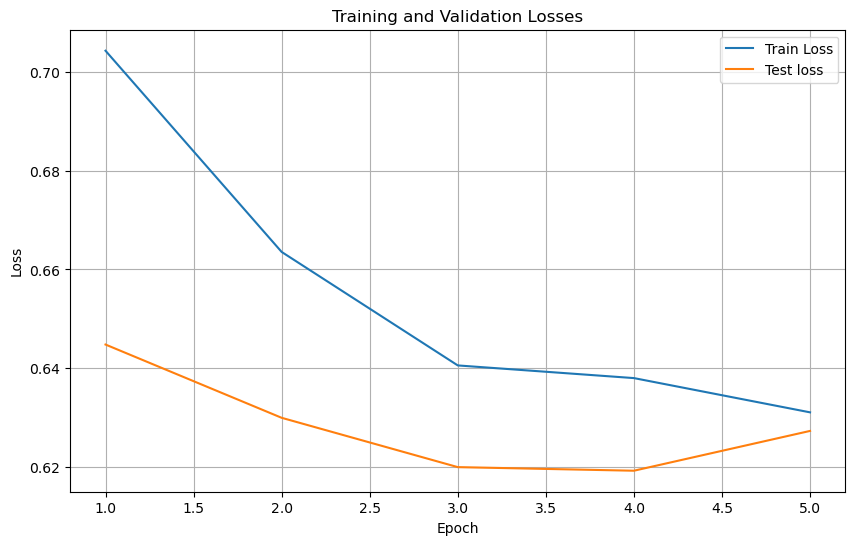

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label='Test loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
model.eval()
with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.to(model.model[0].weight.device)
        targets = targets.to(model.model[0].weight.device)
        
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = (correct / total)*100
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


Test Loss: 0.6273, Test Accuracy: 69.10%
